In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report,roc_curve,auc,RocCurveDisplay
import pandas as pd
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# from tensorflow.keras.applications.resnet50 import preprocess_input
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from collections import Counter
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check for available GPUs and configure TensorFlow to use one
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Set the GPU to be used
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU: ", gpus[0])
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs
Using GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
BATCH_SIZE =128
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def _parse_image_function(example_proto):
    # Parse the input tf.train.Example proto using the dictionary below.
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_png(example['image'], channels=3)
    image = tf.cast(image, tf.float32)
    label = tf.cast(example['label'], tf.int32)
    return image, label

def dataset_from_tfrecords(tfrecords_paths, batch_size=BATCH_SIZE, shuffle=False, shuffle_buffer=1024):
    if not tfrecords_paths:
        print("Warning: tfrecords_paths is empty, returning an empty dataset.")
        return tf.data.Dataset.from_tensor_slices(tf.constant([], dtype=tf.string))

    files_ds = tf.data.Dataset.from_tensor_slices(tfrecords_paths)
    if shuffle:
        files_ds = files_ds.shuffle(len(tfrecords_paths))

    ds = files_ds.interleave(
        tf.data.TFRecordDataset,
        cycle_length=tf.data.AUTOTUNE,
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer)
    ds = ds.map(_parse_image_function, num_parallel_calls=tf.data.AUTOTUNE)
    # One-hot encode the labels
    # ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=2)), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


real_face_test="/content/drive/My Drive/Research Project/dataset/Real_Face/test.tfrecord"
stylegan2_test="/content/drive/My Drive/Research Project/dataset/Stylegan2/test.tfrecord"
stylegan3_test="/content/drive/My Drive/Research Project/dataset/Stylegan3/test.tfrecord"
new_faces_test="/content/drive/My Drive/Research Project/dataset/New_faces/test.tfrecord"
# Combine the two lists of TFRecord file paths
all_test_tfrecords_stylegan2 = [real_face_test ,stylegan2_test]
all_test_tfrecords_stylegan3 = [real_face_test ,stylegan3_test]
all_test_tfrecords_new_faces = [real_face_test ,new_faces_test]
print("All train TFRecord files:", all_test_tfrecords_stylegan2)
print("All train TFRecord files:", all_test_tfrecords_stylegan3)
print("All train TFRecord files:", all_test_tfrecords_new_faces)


test_dataset_stylegan2 = dataset_from_tfrecords(all_test_tfrecords_stylegan2, batch_size=BATCH_SIZE,shuffle=False)
test_dataset_stylegan3 = dataset_from_tfrecords(all_test_tfrecords_stylegan3, batch_size=BATCH_SIZE,shuffle=False)
test_dataset_new_faces = dataset_from_tfrecords(all_test_tfrecords_new_faces, batch_size=BATCH_SIZE,shuffle=False)


print("Datasets are loaded from TFRecord shards, batched, prefetched, and cached.")

All train TFRecord files: ['/content/drive/My Drive/Research Project/dataset/Real_Face/test.tfrecord', '/content/drive/My Drive/Research Project/dataset/Stylegan2/test.tfrecord']
All train TFRecord files: ['/content/drive/My Drive/Research Project/dataset/Real_Face/test.tfrecord', '/content/drive/My Drive/Research Project/dataset/Stylegan3/test.tfrecord']
All train TFRecord files: ['/content/drive/My Drive/Research Project/dataset/Real_Face/test.tfrecord', '/content/drive/My Drive/Research Project/dataset/New_faces/test.tfrecord']
Datasets are loaded from TFRecord shards, batched, prefetched, and cached.


In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/rp/efficientnet/efficient_net_new_10-12_1.keras")

In [ ]:
y_pred_stylegan2=model.predict(test_dataset_stylegan2)

28/28 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
y_pred_stylegan3=model.predict(test_dataset_stylegan3)

28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 970ms/step


In [ ]:
y_pred_new_faces=model.predict(test_dataset_new_faces)

25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step


In [ ]:
y_true_stylegan2 = []
for _, labels in test_dataset_stylegan2:
    y_true_stylegan2.extend(labels.numpy())

In [ ]:
y_true_stylegan3=[]
for _, labels in test_dataset_stylegan3:
    y_true_stylegan3.extend(labels.numpy())

In [ ]:
y_true_new_faces=[]
for _, labels in test_dataset_new_faces:
    y_true_new_faces.extend(labels.numpy())

Stylegan2 and Real Face

Stylegan2 and Real Face F1-Score:0.8397058823529412
              precision    recall  f1-score   support

           0       0.95      0.66      0.78      1750
           1       0.74      0.97      0.84      1775

    accuracy                           0.81      3525
   macro avg       0.85      0.81      0.81      3525
weighted avg       0.85      0.81      0.81      3525



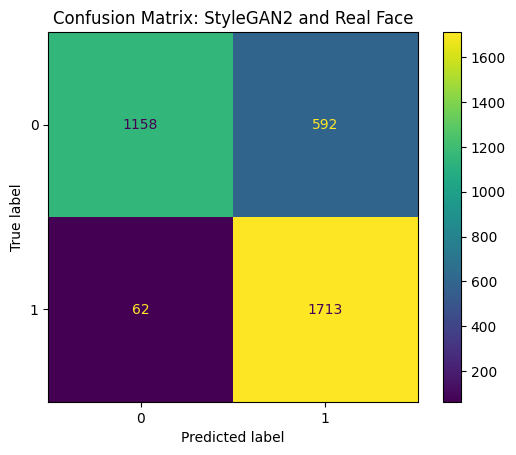

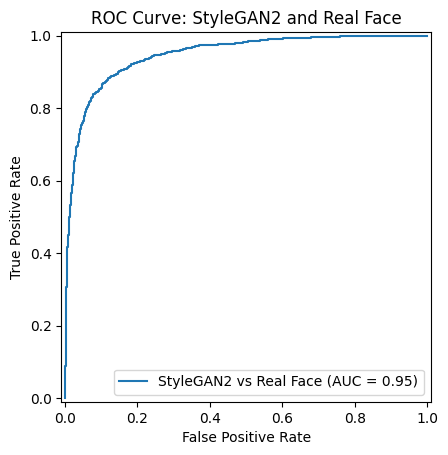

In [ ]:
f1_2=f1_score(y_true_stylegan2, np.argmax(y_pred_stylegan2, axis=1))
print(f"Stylegan2 and Real Face F1-Score:{f1_2}")
cr_2=classification_report(y_true_stylegan2, np.argmax(y_pred_stylegan2, axis=1))
print(cr_2)
cm_2=confusion_matrix(y_true_stylegan2, np.argmax(y_pred_stylegan2, axis=1))

# Plot confusion matrix
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_2)
disp_2.plot()
plt.title('Confusion Matrix: StyleGAN2 and Real Face')
plt.show()

# Calculate and plot ROC AUC curve
fpr_2, tpr_2, thresholds_2 = roc_curve(y_true_stylegan2, y_pred_stylegan2[:, 1])
roc_auc_2 = auc(fpr_2, tpr_2)

roc_display_2 = RocCurveDisplay(fpr=fpr_2, tpr=tpr_2, roc_auc=roc_auc_2, estimator_name='StyleGAN2 vs Real Face')
roc_display_2.plot()
plt.title('ROC Curve: StyleGAN2 and Real Face')
plt.show()

Stylegan3 and Real Face

Stylegan3 and Real Face F1-Score:0.8296662546353523
              precision    recall  f1-score   support

           0       0.92      0.66      0.77      1750
           1       0.74      0.95      0.83      1775

    accuracy                           0.80      3525
   macro avg       0.83      0.80      0.80      3525
weighted avg       0.83      0.80      0.80      3525



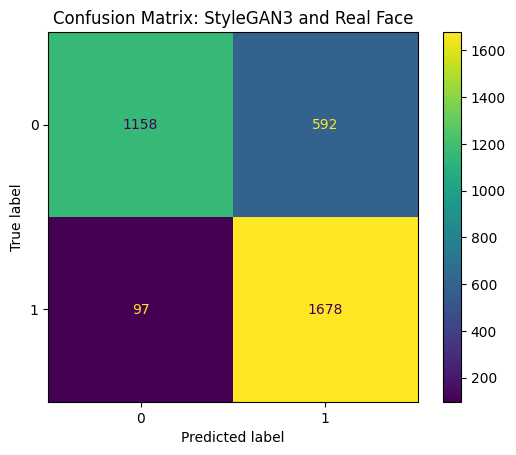

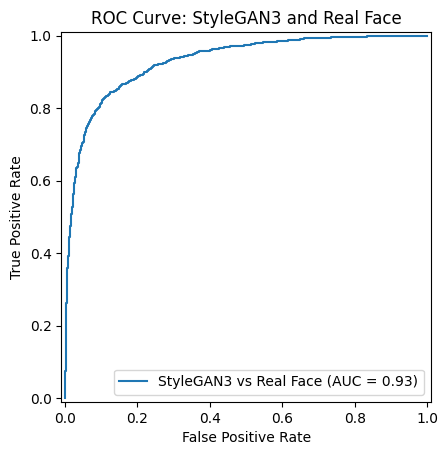

In [ ]:
f1_3=f1_score(y_true_stylegan3, np.argmax(y_pred_stylegan3, axis=1))
print(f"Stylegan3 and Real Face F1-Score:{f1_3}")
cr_3=classification_report(y_true_stylegan3, np.argmax(y_pred_stylegan3, axis=1))
print(cr_3)
cm_3=confusion_matrix(y_true_stylegan3, np.argmax(y_pred_stylegan3, axis=1))

# Plot confusion matrix
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_3)
disp_3.plot()
plt.title('Confusion Matrix: StyleGAN3 and Real Face')
plt.show()

# Calculate and plot ROC AUC curve
fpr_3, tpr_3, thresholds_3 = roc_curve(y_true_stylegan3, y_pred_stylegan3[:, 1])
roc_auc_3 = auc(fpr_3, tpr_3)

roc_display_3 = RocCurveDisplay(fpr=fpr_3, tpr=tpr_3, roc_auc=roc_auc_3, estimator_name='StyleGAN3 vs Real Face')
roc_display_3.plot()
plt.title('ROC Curve: StyleGAN3 and Real Face')
plt.show()

New Faces

New Faces and Real Face F1-Score:0.8125
              precision    recall  f1-score   support

           0       0.96      0.66      0.78      1750
           1       0.70      0.97      0.81      1441

    accuracy                           0.80      3191
   macro avg       0.83      0.81      0.80      3191
weighted avg       0.84      0.80      0.80      3191



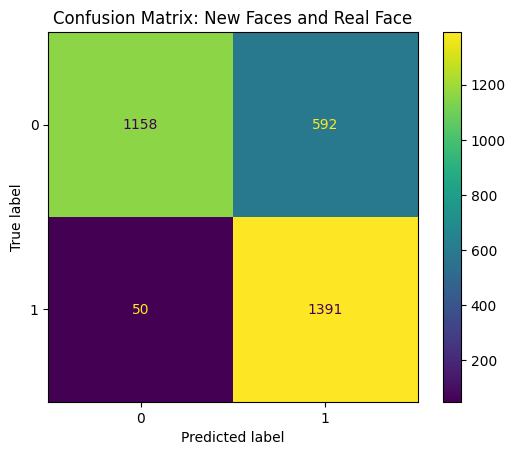

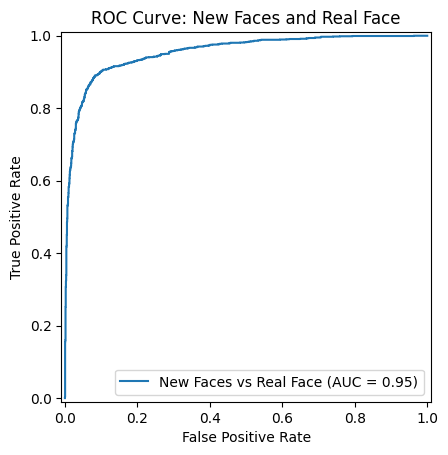

In [ ]:
f1_new_faces=f1_score(y_true_new_faces, np.argmax(y_pred_new_faces, axis=1))
print(f"New Faces and Real Face F1-Score:{f1_new_faces}")
cr_new_faces=classification_report(y_true_new_faces, np.argmax(y_pred_new_faces, axis=1))
print(cr_new_faces)
cm_new_faces=confusion_matrix(y_true_new_faces, np.argmax(y_pred_new_faces, axis=1))

# Plot confusion matrix
disp_new_faces = ConfusionMatrixDisplay(confusion_matrix=cm_new_faces)
disp_new_faces.plot()
plt.title('Confusion Matrix: New Faces and Real Face')
plt.show()

# Calculate and plot ROC AUC curve
fpr_new_faces, tpr_new_faces, thresholds_new_faces = roc_curve(y_true_new_faces, y_pred_new_faces[:, 1])
roc_auc_new_faces = auc(fpr_new_faces, tpr_new_faces)

roc_display_new_faces = RocCurveDisplay(fpr=fpr_new_faces, tpr=tpr_new_faces, roc_auc=roc_auc_new_faces, estimator_name='New Faces vs Real Face')
roc_display_new_faces.plot()
plt.title('ROC Curve: New Faces and Real Face')
plt.show()